##  An Efficient Multiple Convolutional Neural Network Model (MCNN-14) for Fashion Image Classification 
- Sajjad Saed
- Babak Teimourpour
- Kamand Kalashi
- Mohammad Ali Soltanshahi
# ************************************************************************

-  Fashion-Mnist Dataset

In [1]:
# Importing required libraries
# Feature extraction and feature selection
import numpy as np
import pandas as pd

# imqage processing and visualization
import cv2
import tqdm as tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data training and create cnn model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import itertools
import ipywidgets as widgets

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

In [2]:
 # load dataset
mnist_dataset = tf.keras.datasets.fashion_mnist

In [3]:
# load train and test data
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

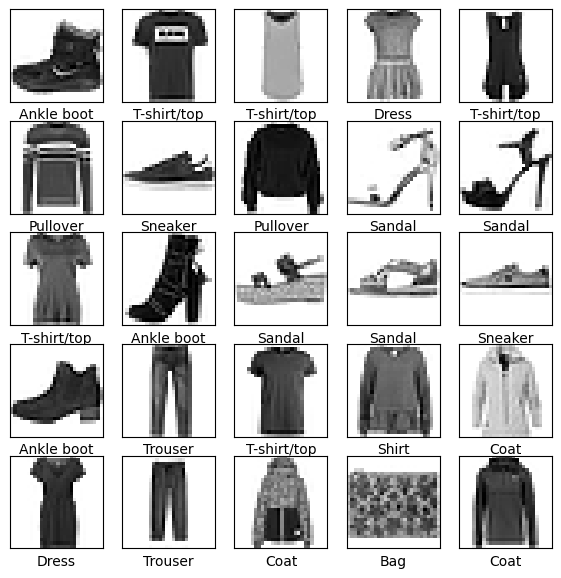

In [5]:
plt.figure(figsize=(7,7))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])

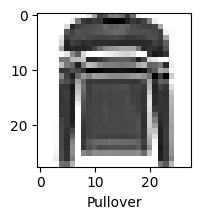

In [8]:
# Select an image
img_index1 = 5 # Change this index to select a different image
img1 = train_images[img_index1]

# Display the selected image
plt.figure(figsize=(2, 2))
plt.imshow(img1, cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[img_index1]])
plt.show()

# Process the image to fit model input
# Add the image dimension if your model expects it
img1 = np.expand_dims(img1, axis=-1) # Add channel dimension
img1 = np.expand_dims(img1, axis=0)  # Add batch dimension
img1 = img1 / 255.0  # Normalize to [0, 1]


In [9]:
# reshape dataset to have a single channel
X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
X_test = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [10]:
X_train.shape

(60000, 28, 28, 1)

In [11]:
X_test.shape

(10000, 28, 28, 1)

In [12]:
# Data Preprocessing
Y_train = train_labels
Y_test = test_labels
# normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [13]:
Y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [14]:
# one hot encode target values
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)

In [15]:
Y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
# Data Preprocessing
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    featurewise_std_normalization=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    fill_mode='nearest'
)

In [17]:
from keras.layers import BatchNormalization
from tensorflow.keras import regularizers
# proposed CNN Model architecture (SK-CNN)
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same'))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 192, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
# model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 batch_normalization (Batch  (None, 28, 28, 256)       1024      
 Normalization)                                                  
                                                        

In [18]:
# Fit the ImageDataGenerator to the training data
datagen.fit(X_train)

# Use the .flow() method to prepare the iterator
train_generator = datagen.flow(X_train, Y_train)

In [19]:
# adam_optimizer = Adam(lr = 0.001278, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)
adam_optimizer = Adam(lr = 0.0011, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_optimizer, metrics = ['accuracy'])

In [21]:
fashion_mnist_reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 2, mode = 'auto', factor = 0.3, min_lr = 0.000001)
fashion_mnist_tensorboard = TensorBoard(log_dir = 'logs')
fashion_mnist_checkpoint = ModelCheckpoint("MCNN_14_5.h5", monitor = 'val_accuracy', verbose = 2, save_best_only = True, mode = 'auto')
fashion_mnist_early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, mode = 'max')

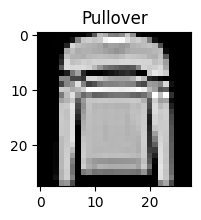

In [59]:
# Select an image
img_index2 = 5  # Feel free to change this index to visualize different images
img2 = X_train[img_index2]

# Display the selected image
plt.figure(figsize=(2, 2))
plt.imshow(img2.reshape(28, 28), cmap='gray')  # Reshape and display the image
plt.title(class_names[np.argmax(Y_train[img_index2])])  # Show the image's label as title
plt.show()


In [60]:
# summarize feature map size for each conv layer

# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d (None, 28, 28, 32)
1 conv2d_1 (None, 28, 28, 64)
2 conv2d_2 (None, 28, 28, 128)
4 conv2d_3 (None, 28, 28, 256)
8 conv2d_4 (None, 14, 14, 192)
9 conv2d_5 (None, 14, 14, 256)
11 conv2d_6 (None, 14, 14, 256)
15 conv2d_7 (None, 7, 7, 128)
16 conv2d_8 (None, 7, 7, 64)
19 conv2d_9 (None, 3, 3, 128)
20 conv2d_10 (None, 3, 3, 256)
22 conv2d_11 (None, 3, 3, 128)
24 conv2d_12 (None, 3, 3, 64)
25 conv2d_13 (None, 3, 3, 32)


In [61]:
# Specify the layers for which you want to visualize the feature maps
# Here, we're selecting all convolutional layers
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]

# Create a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Prepare the image for prediction (add batch dimension)
img_tensor = np.expand_dims(img2, axis=0)


In [62]:
# Get feature maps
feature_maps = activation_model.predict(img_tensor)


1/1 [==============================] - 0s 182ms/step


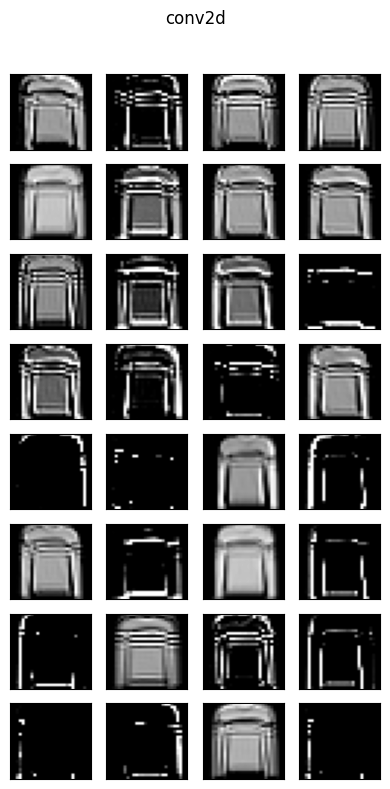

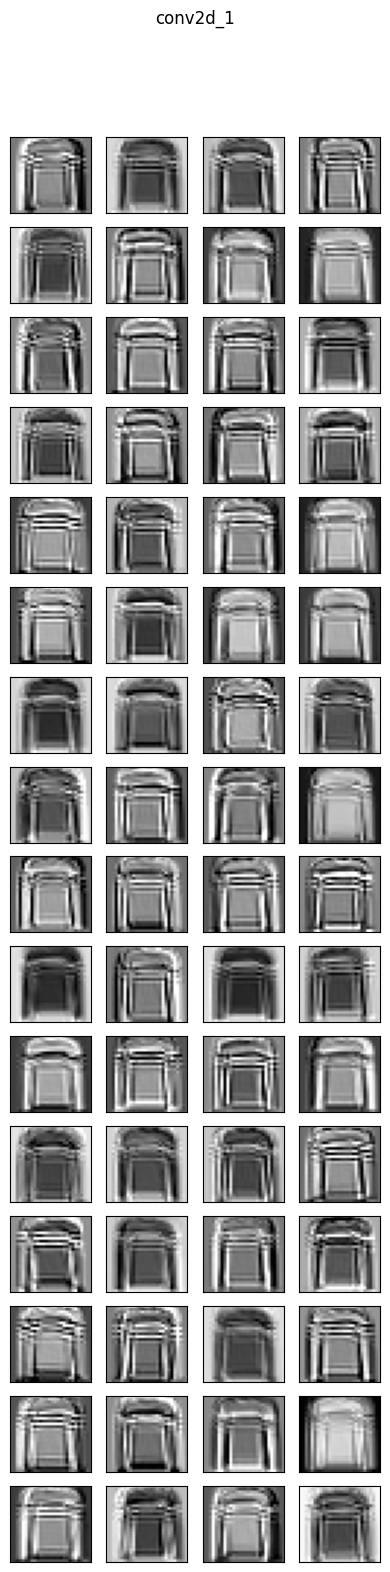

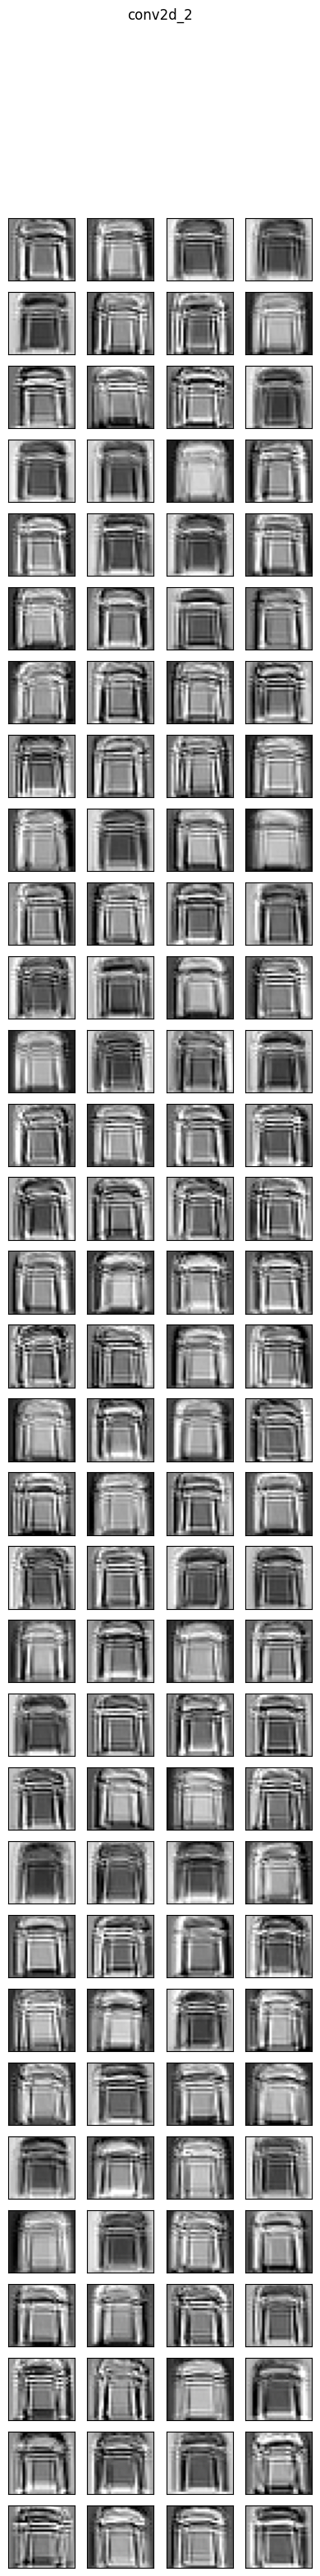

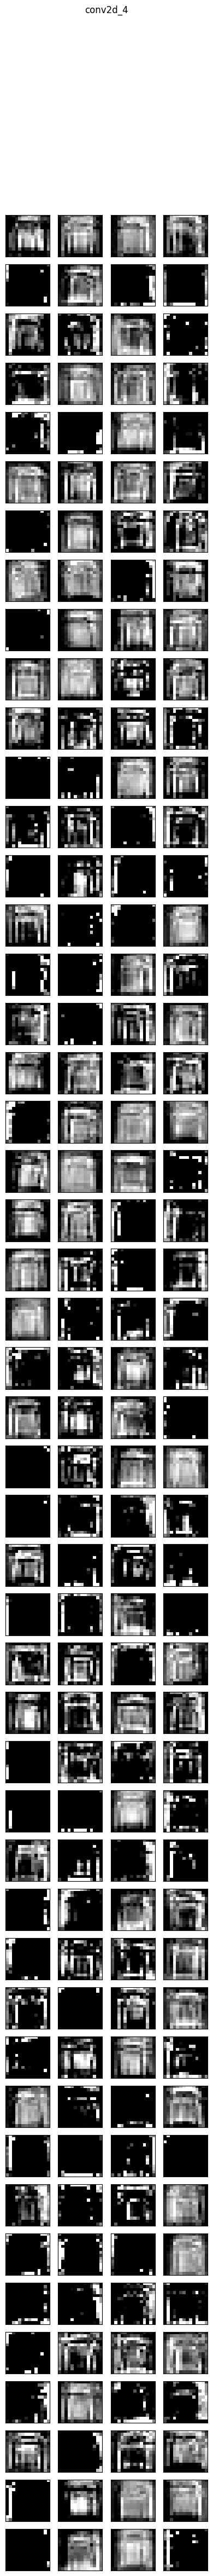

<ipython-input-33-f723ae1bd22a>:28: RuntimeWarning: invalid value encountered in cast
  img = np.clip(img, 0, 255).astype('uint8')


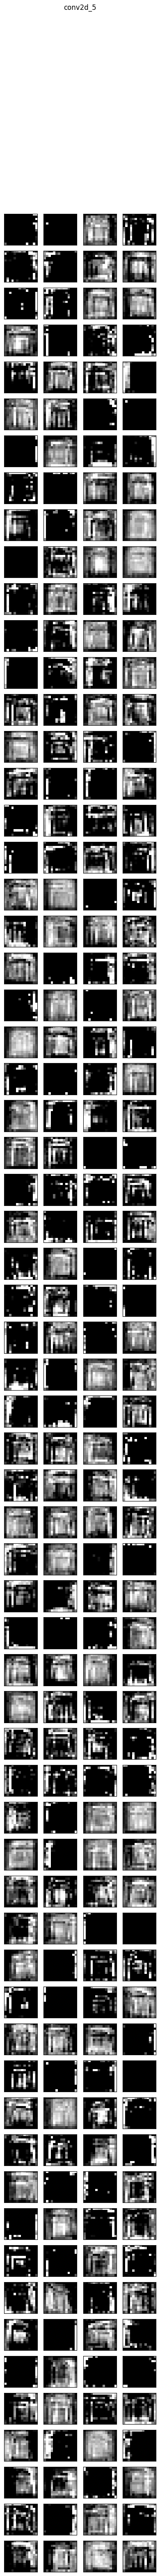

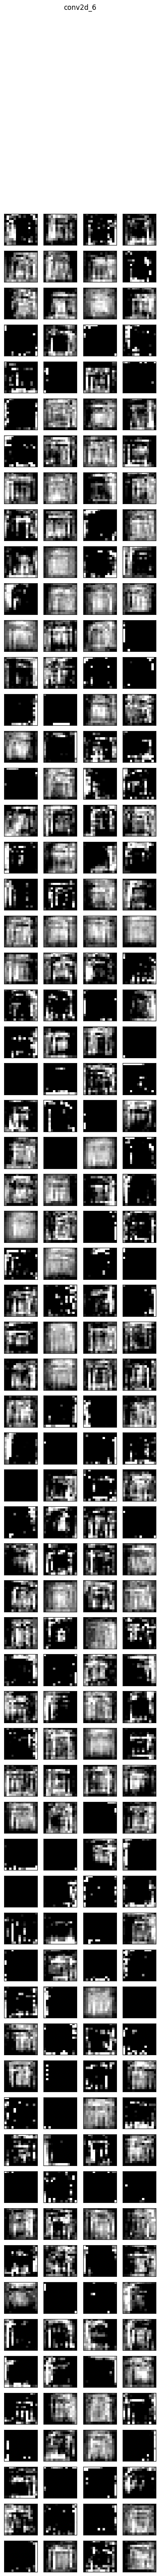

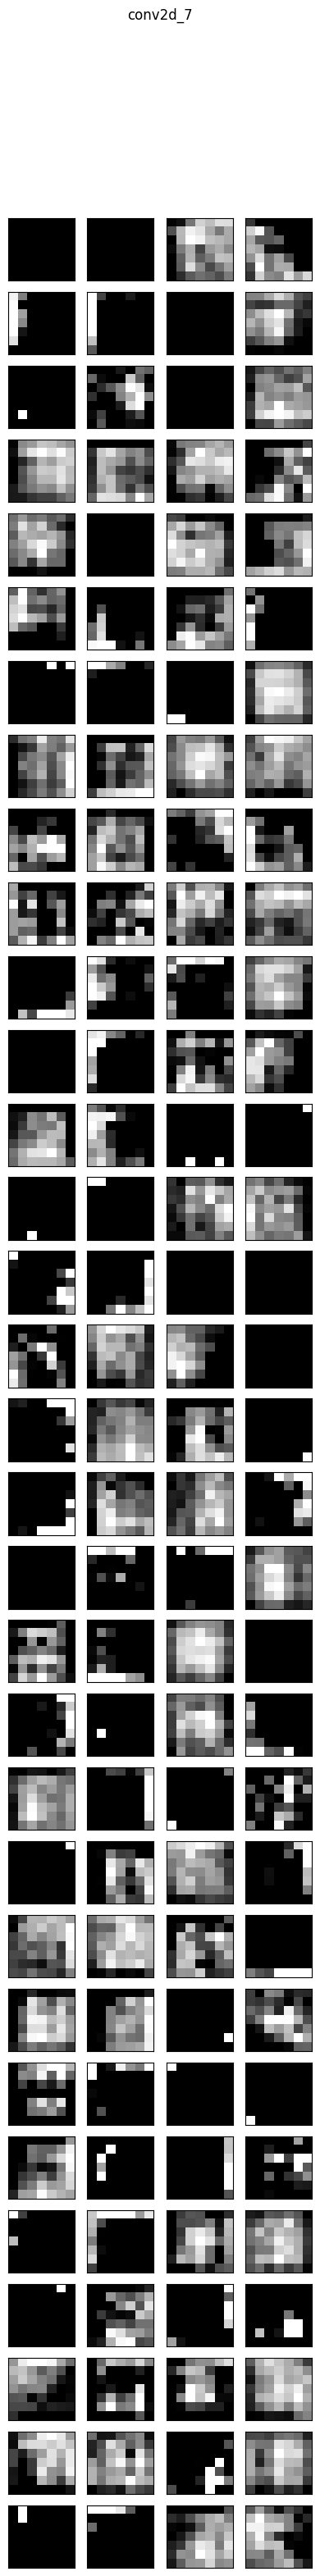

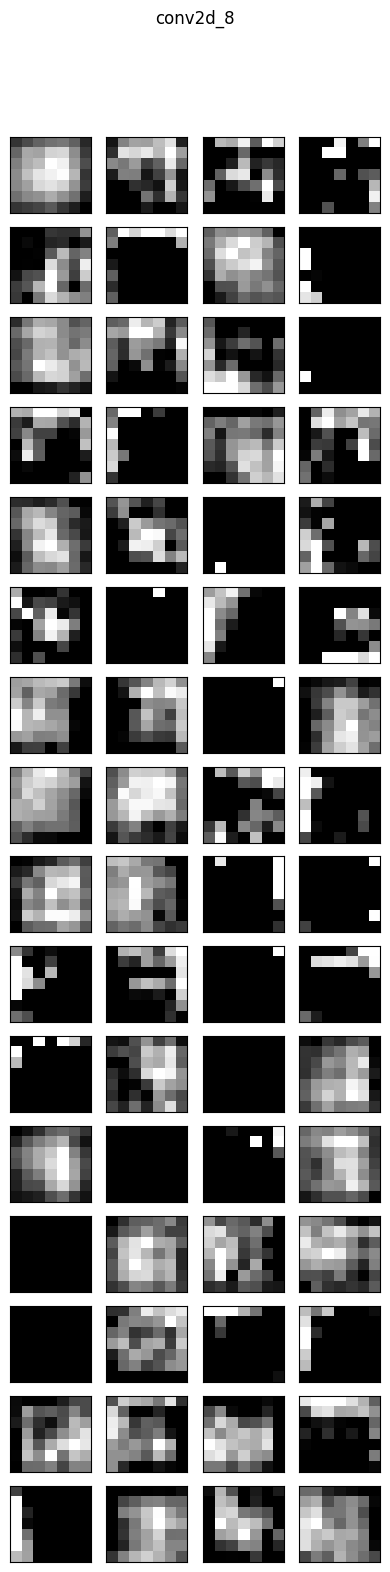

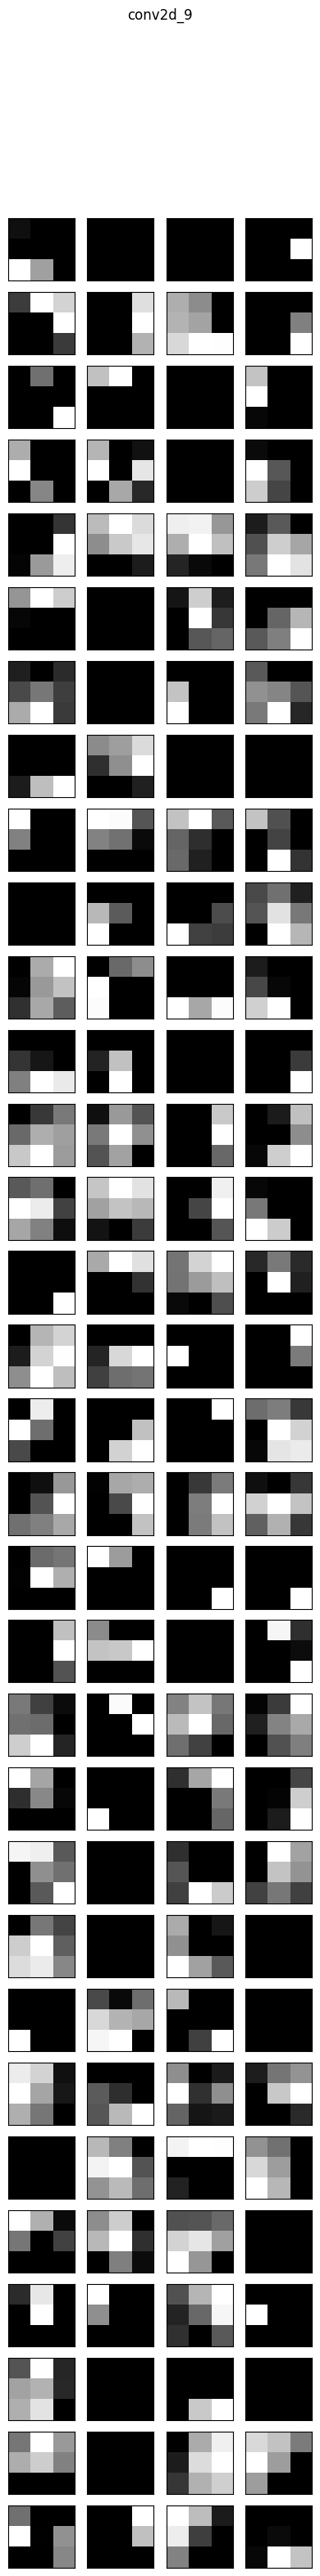

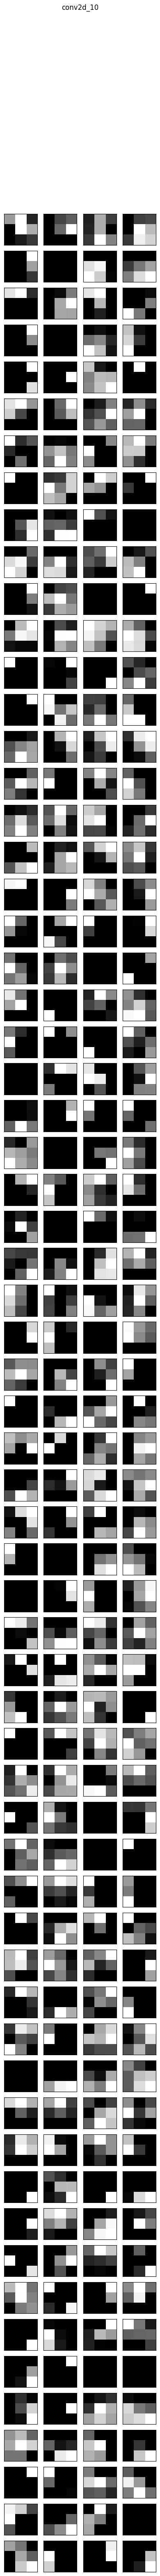

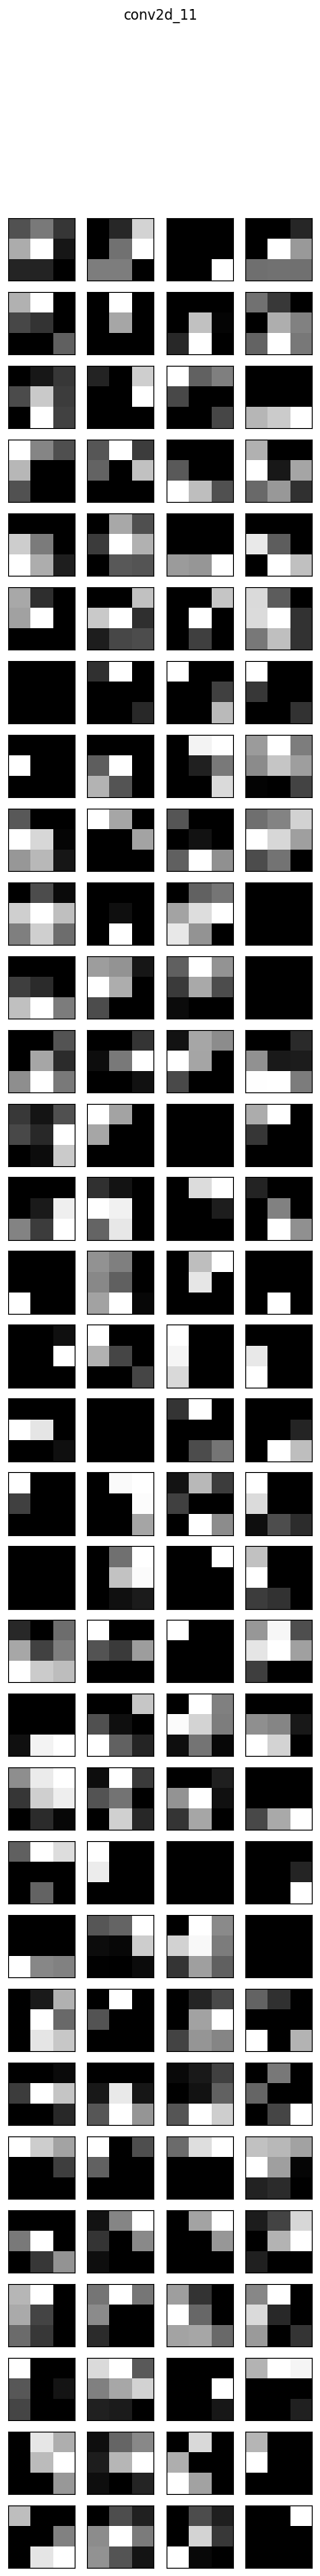

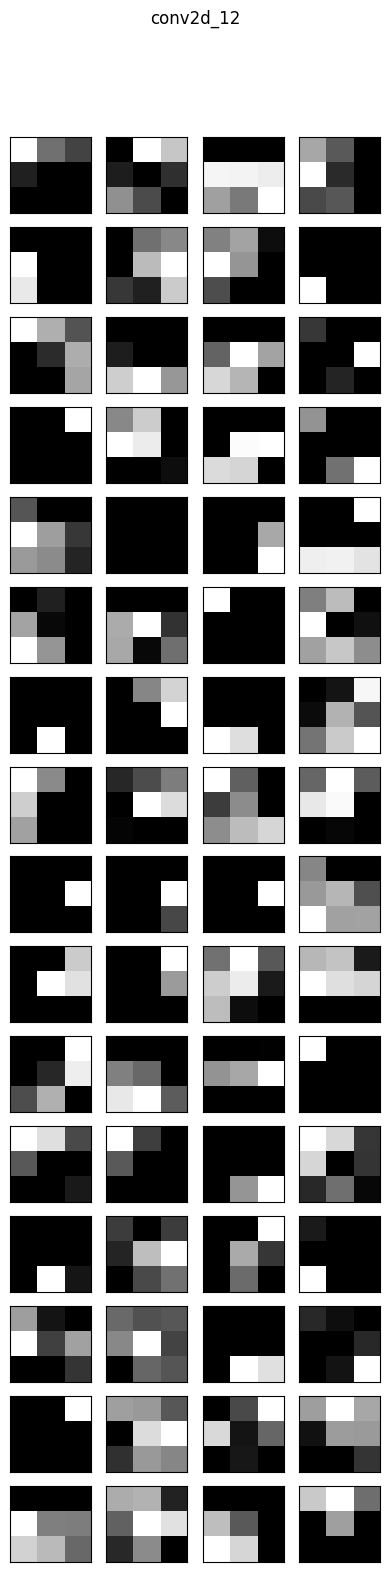

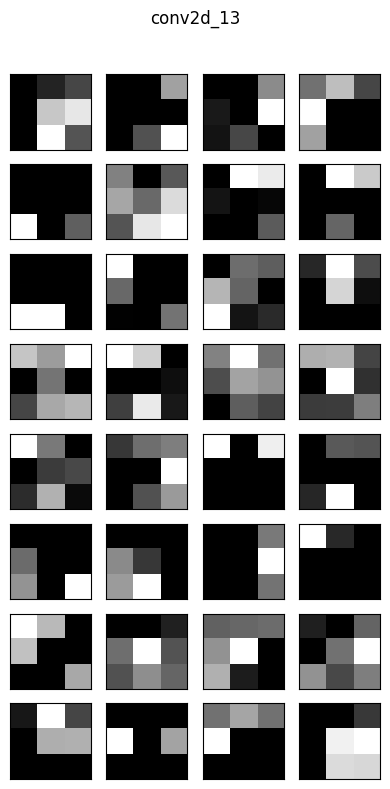

In [33]:
# Iterate over each layer's feature maps
for layer_name, feature_map in zip([layer.name for layer in model.layers if isinstance(layer, Conv2D)], feature_maps):
    n_features = feature_map.shape[-1]  # Number of features in the feature map
    size = feature_map.shape[1]  # The feature map has shape (1, size, size, n_features)

    # Calculate the number of rows we will need
    n_cols = 4
    n_rows = n_features // n_cols + (n_features % n_cols > 0)

    # Set up the matplotlib figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1, n_rows * 1))
    fig.suptitle(layer_name)

    # Plot each feature map
    for i in range(n_rows * n_cols):
        ax = axes[i // n_cols, i % n_cols]
        ax.set_xticks([])
        ax.set_yticks([])

        # Only plot the valid feature maps
        if i < n_features:
            # Postprocess the feature map
            img = feature_map[0, :, :, i]
            img -= img.mean()
            img /= img.std() + 1e-5  # Avoid division by zero
            img *= 64
            img += 128
            img = np.clip(img, 0, 255).astype('uint8')

            ax.imshow(img, aspect='auto', cmap='gray')
        else:
            ax.axis('off')  # Turn off axis for empty plots

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust subplots to fit suptitle
    plt.show()


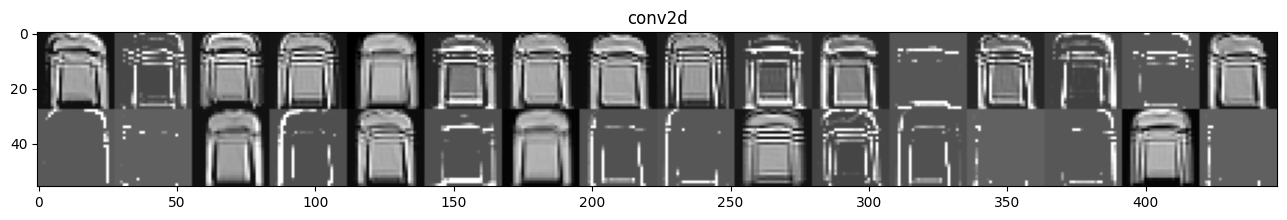

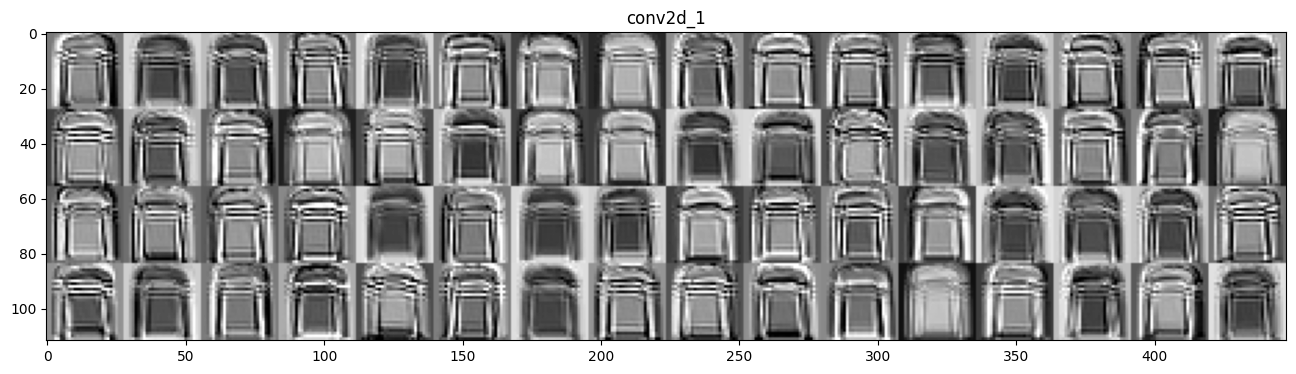

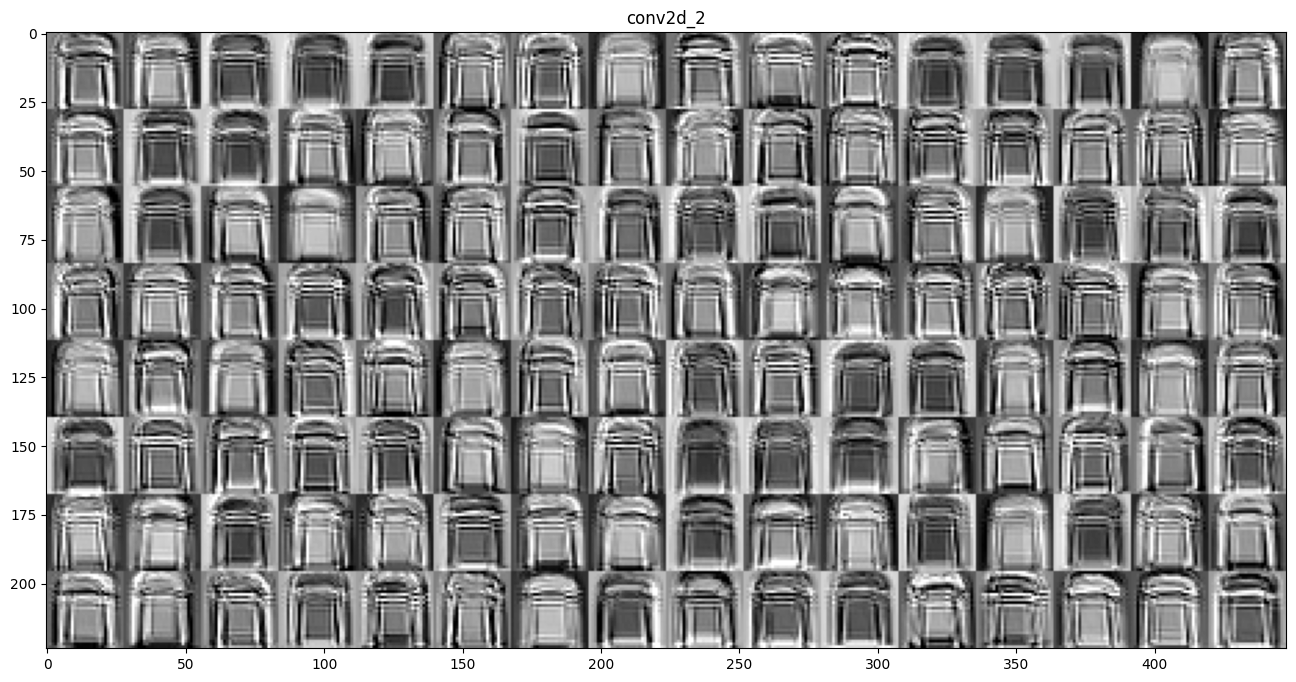

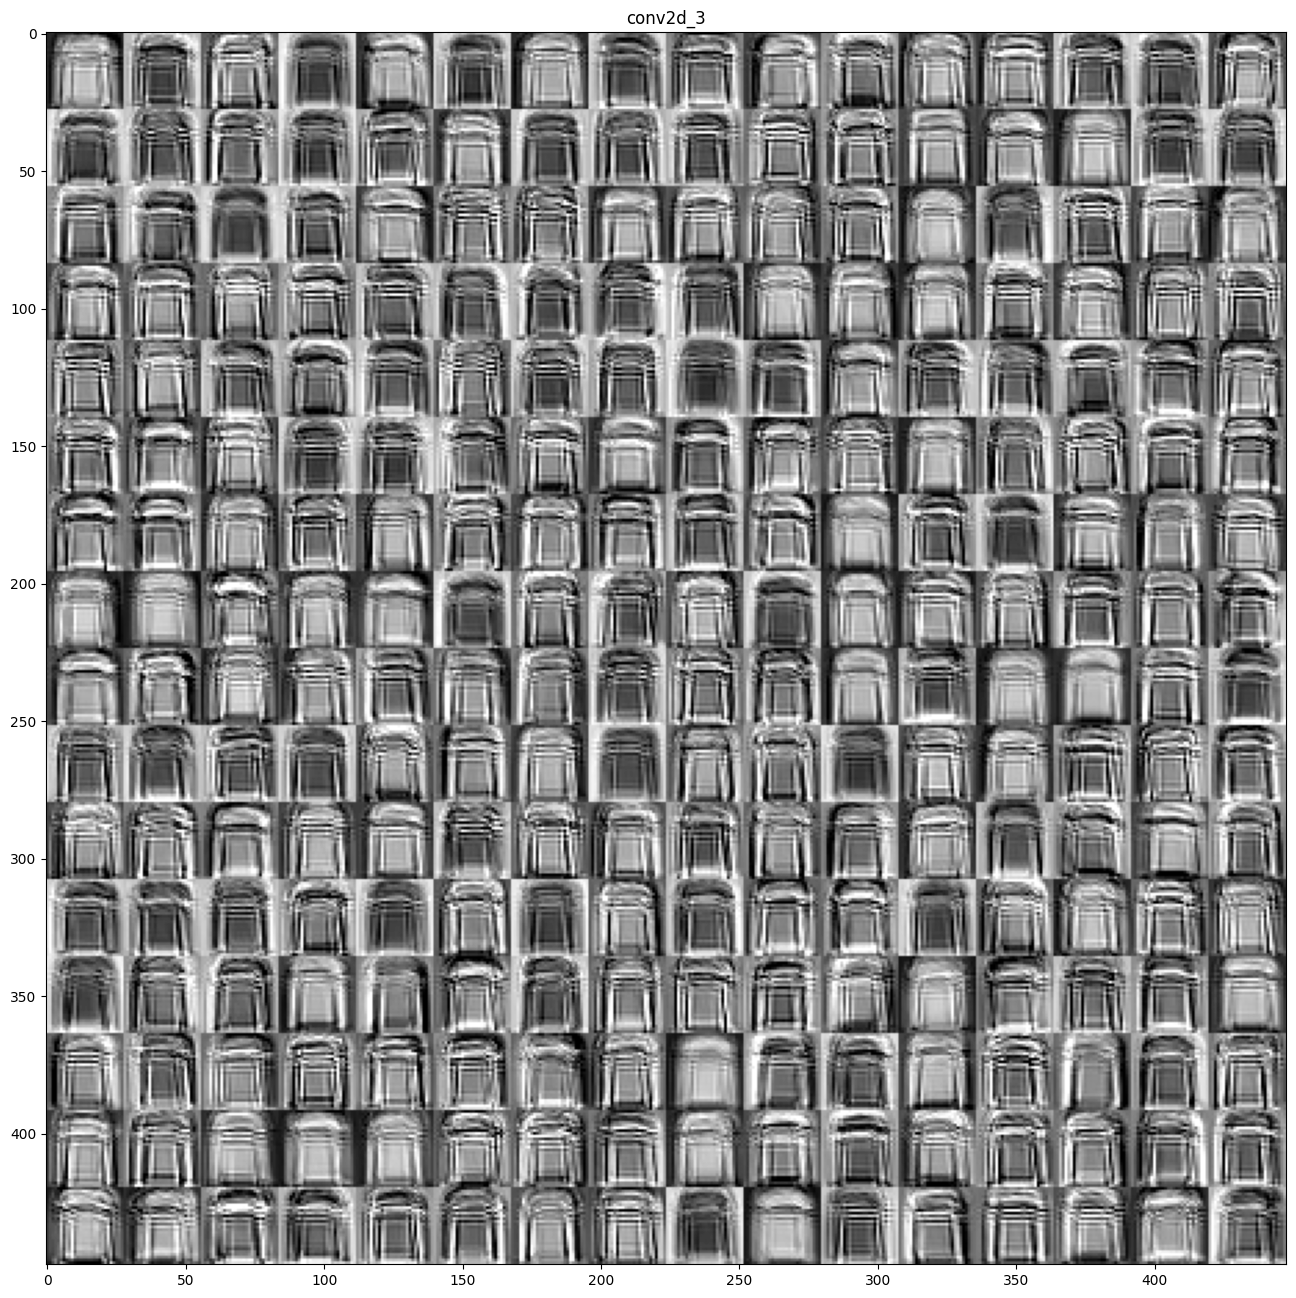

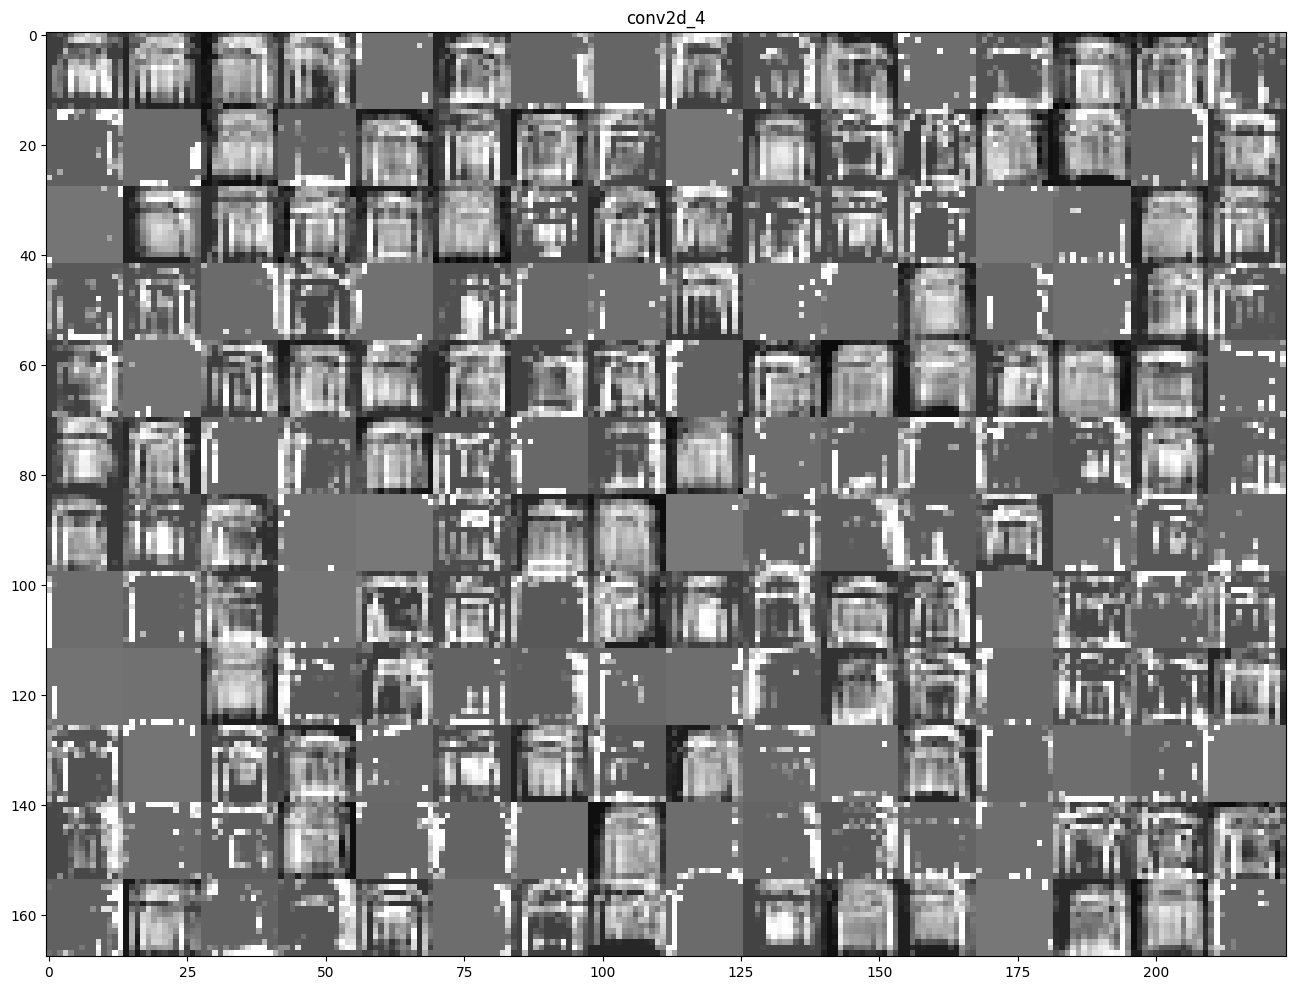

<ipython-input-63-916e01a8db79>:12: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-63-916e01a8db79>:15: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


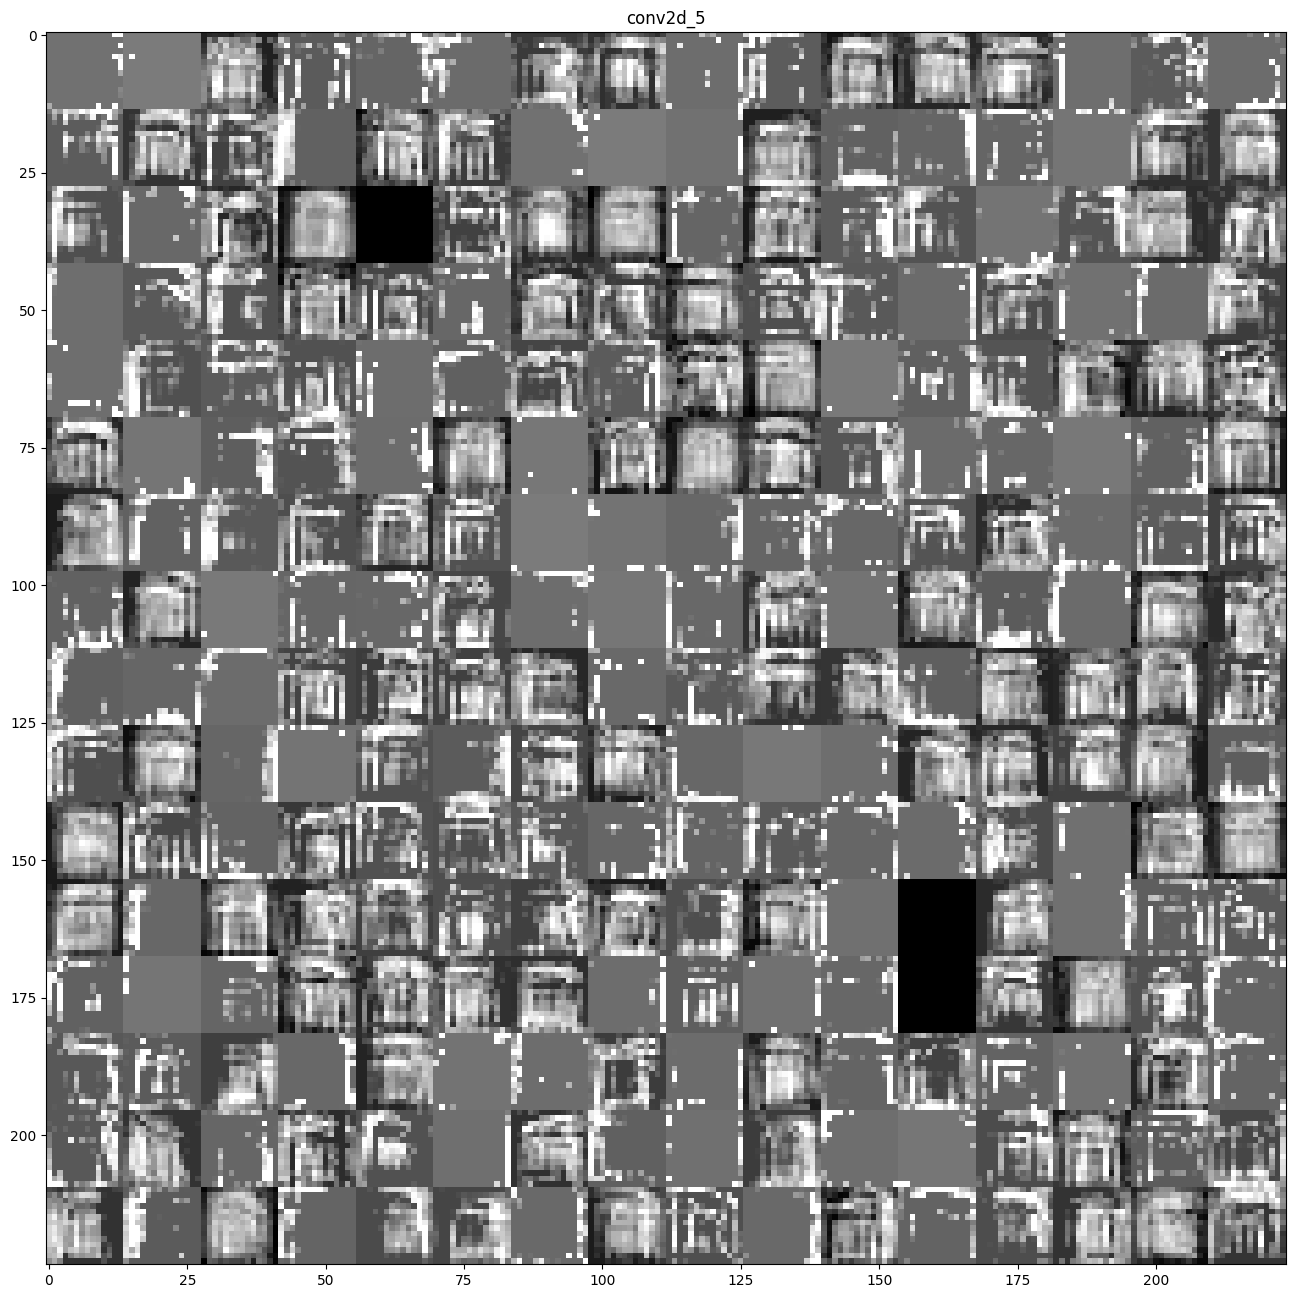

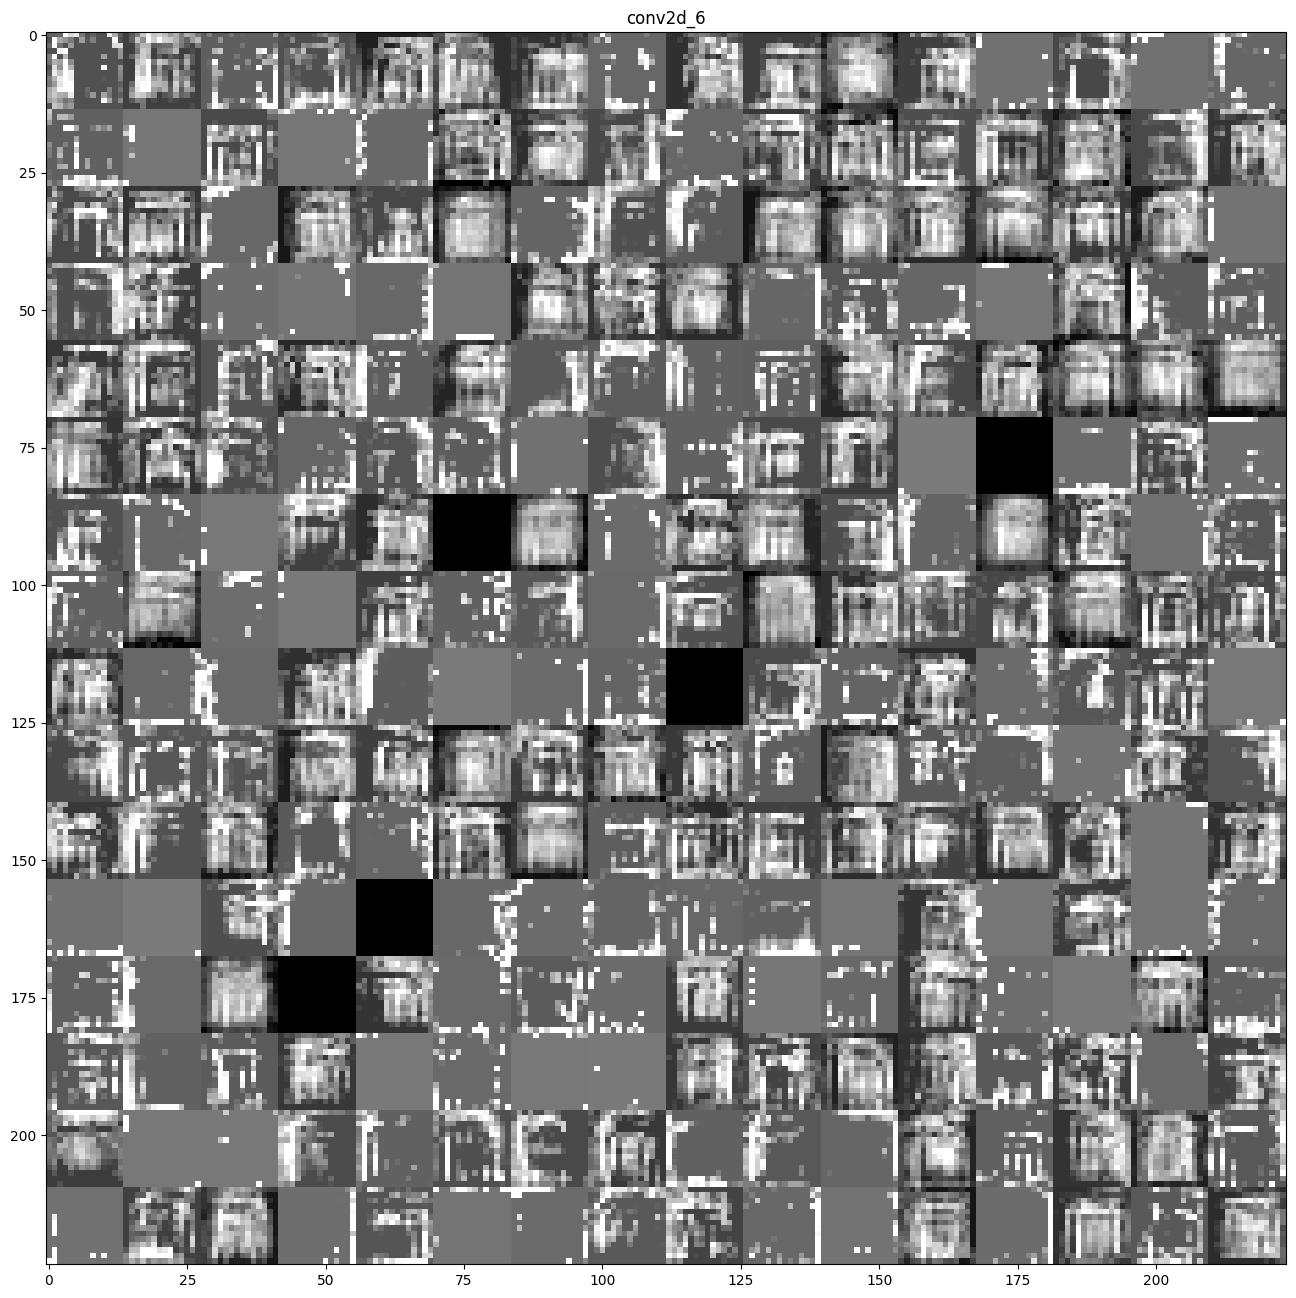

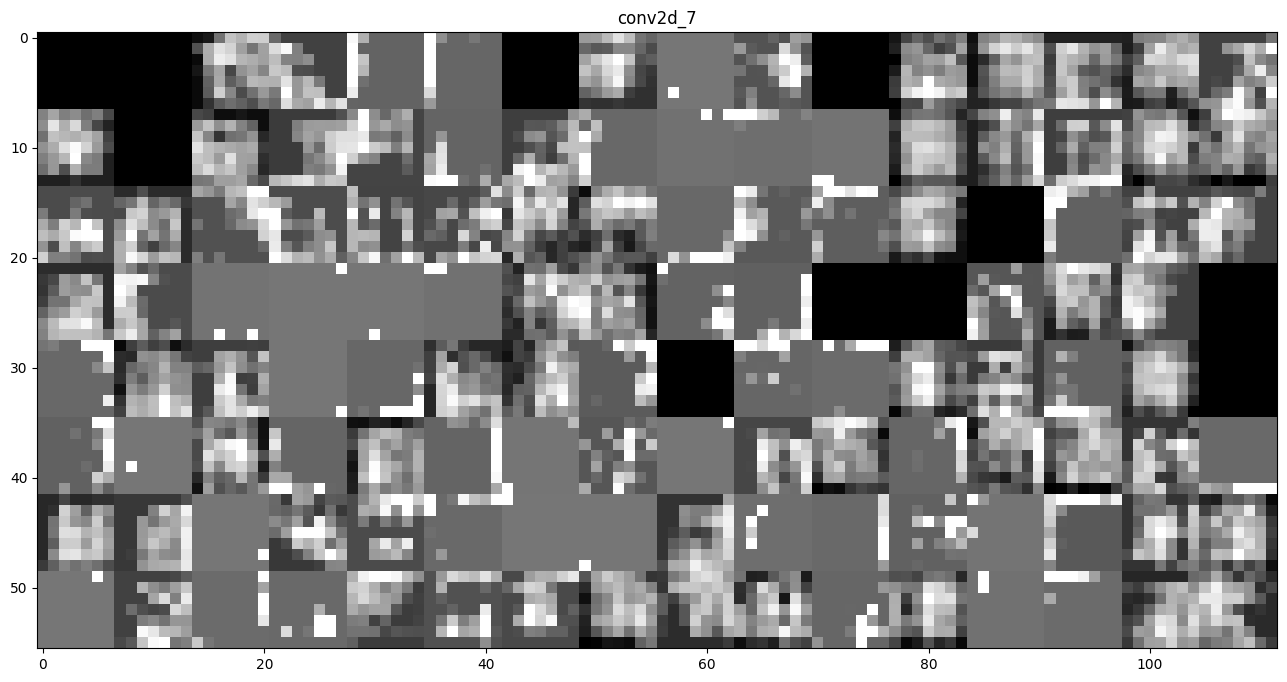

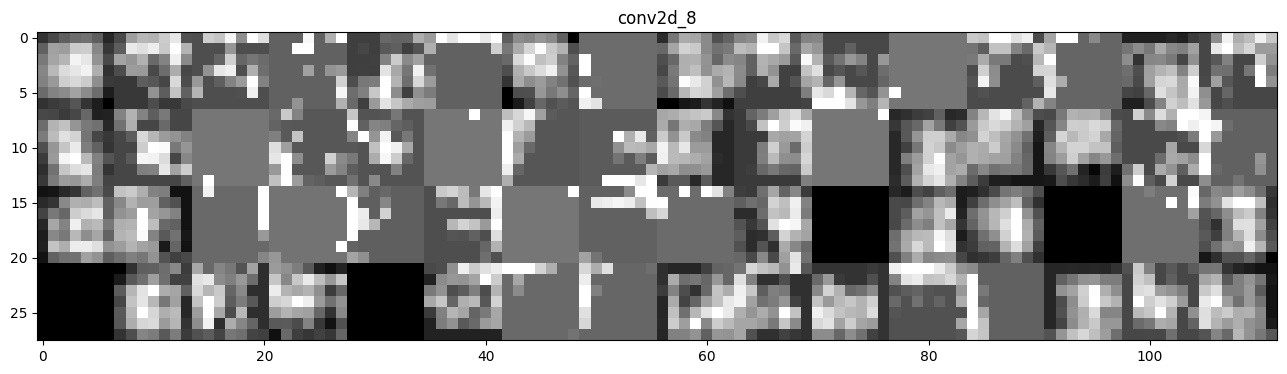

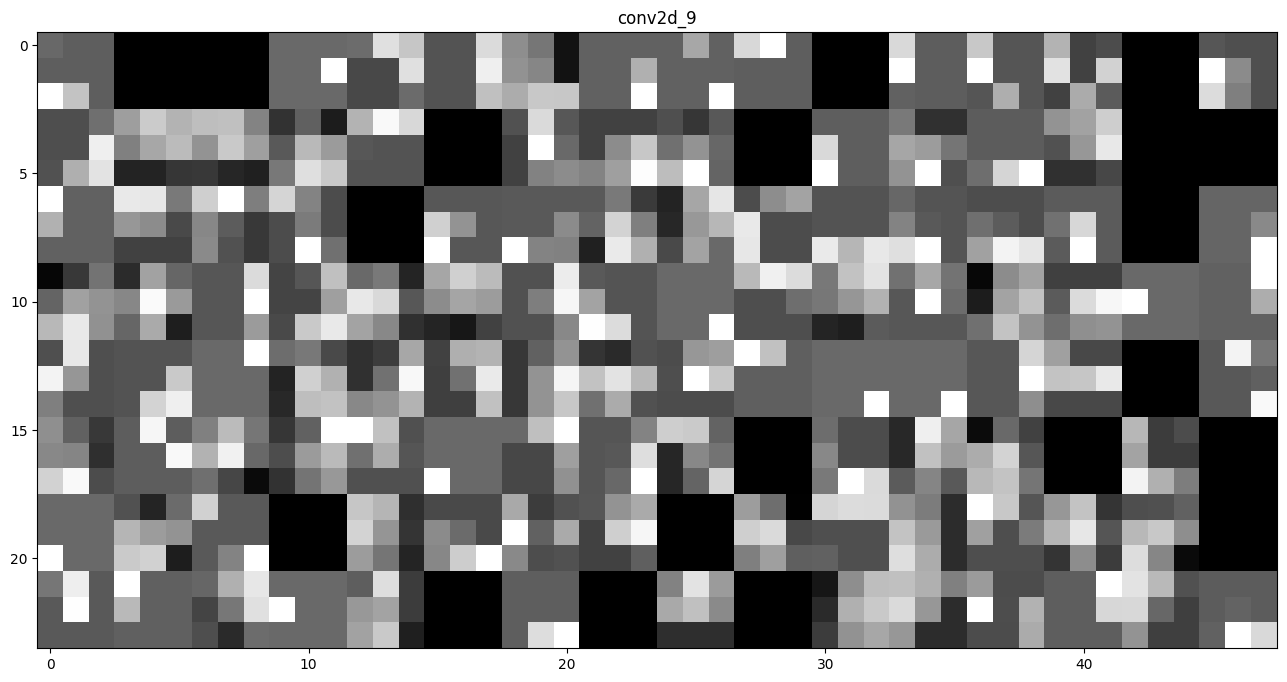

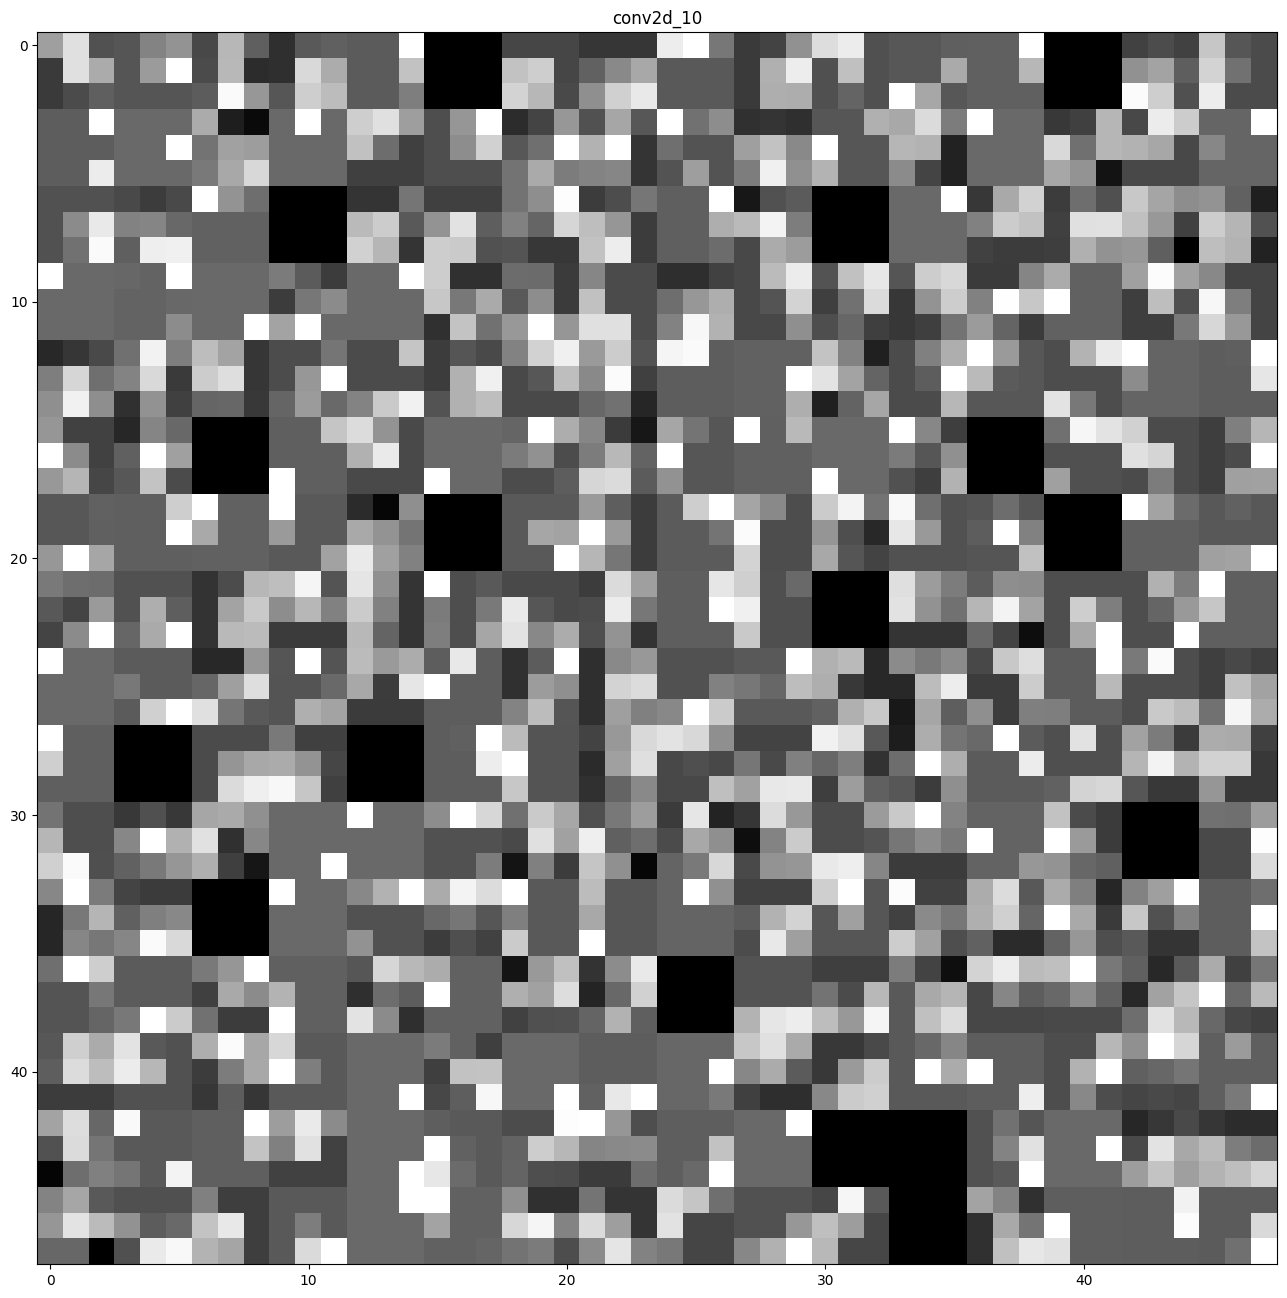

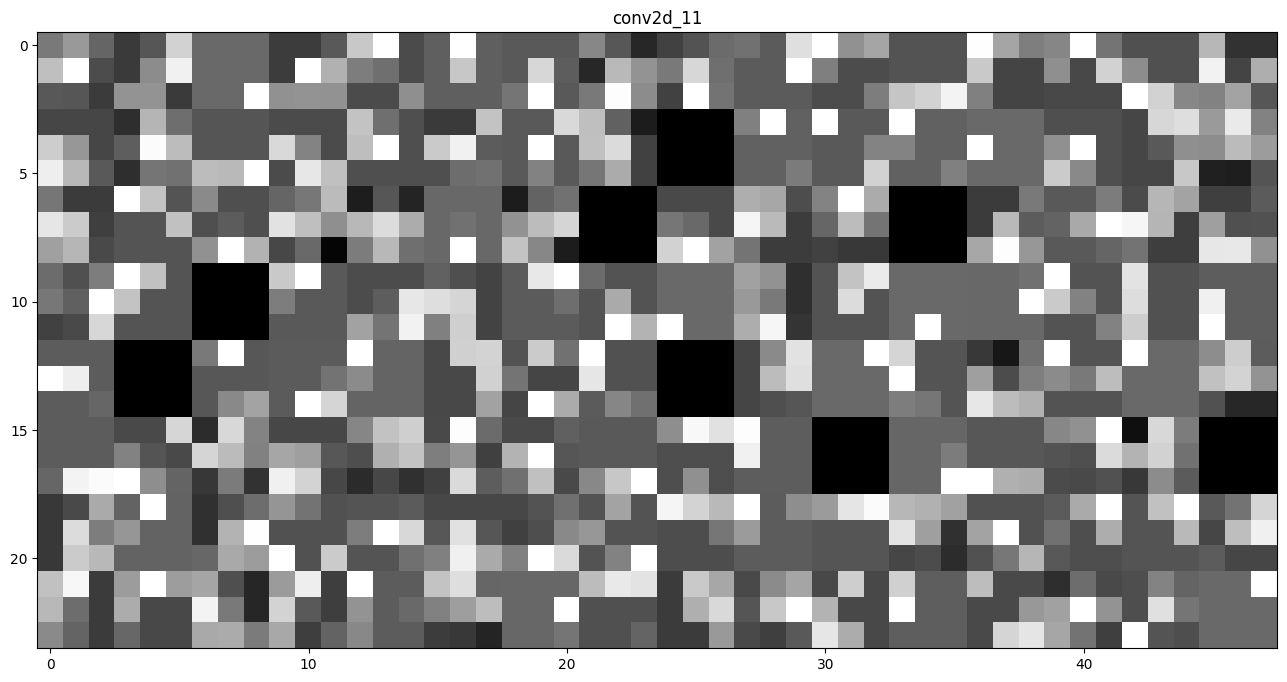

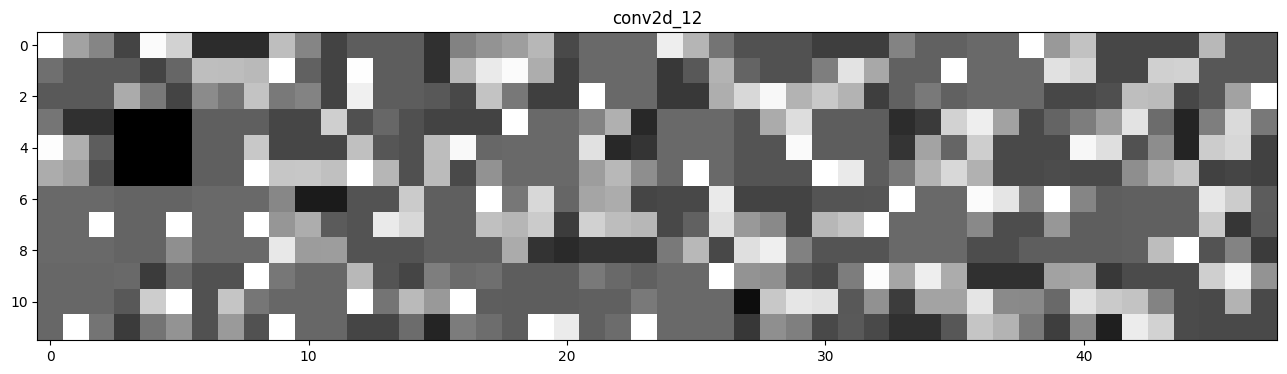

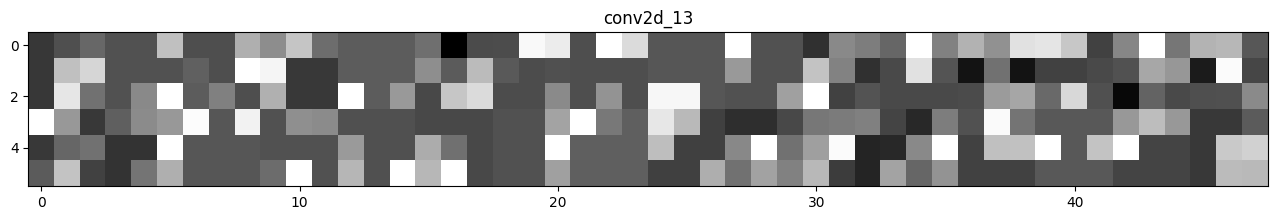

In [63]:
for layer_name, feature_map in zip([layer.name for layer in model.layers if isinstance(layer, Conv2D)], feature_maps):
    n_features = feature_map.shape[-1]  # Number of features in the feature map
    size = feature_map.shape[1]  # The feature map has shape (1, size, size, n_features)
    n_cols = n_features // 16  # We will tile our images in this many columns
    display_grid = np.zeros((size * n_cols, size * 16))

    for col in range(n_cols):
        for row in range(16):
            channel_image = feature_map[0, :, :, col * 16 + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')
    plt.show()


1/1 [==============================] - 1s 605ms/step


<ipython-input-98-e183cf2bbd1a>:29: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-98-e183cf2bbd1a>:32: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')
<ipython-input-98-e183cf2bbd1a>:29: RuntimeWarning: divide by zero encountered in divide
  x /= x.std()


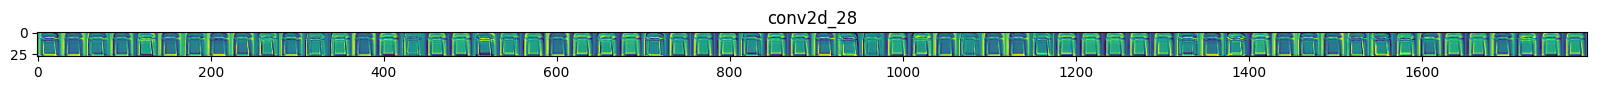

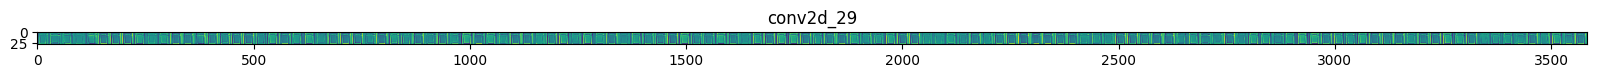

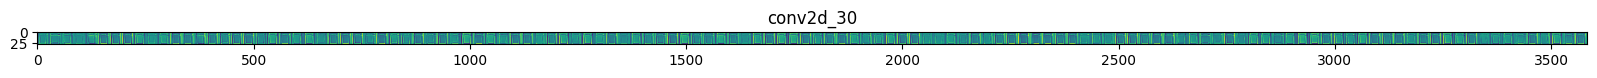

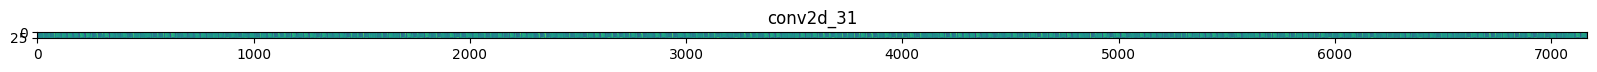

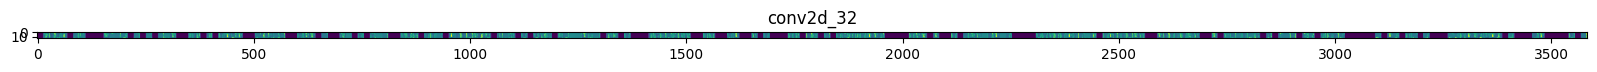

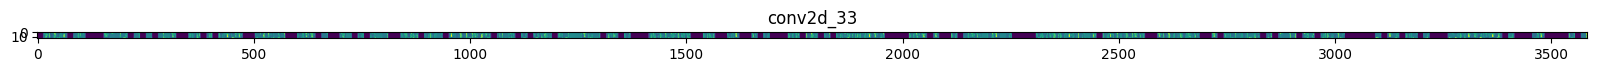

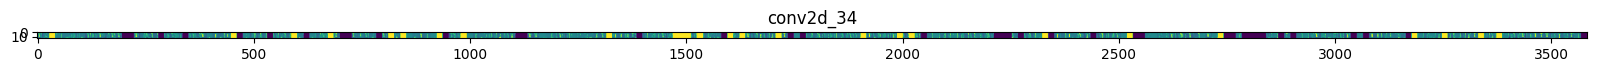

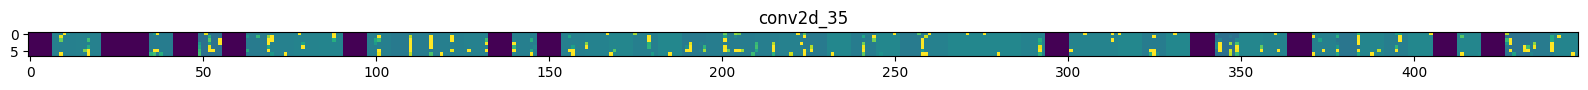

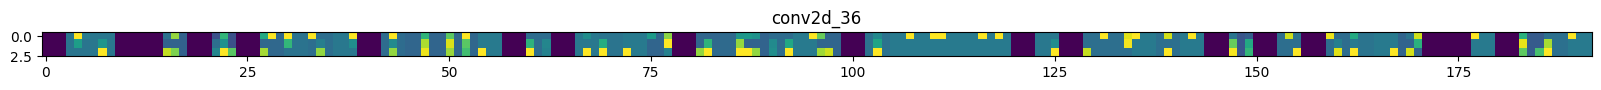

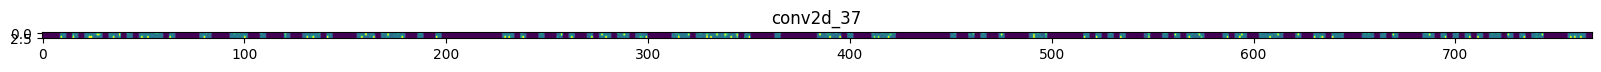

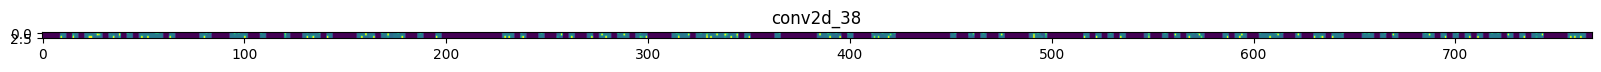

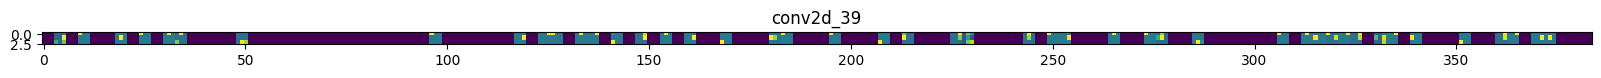

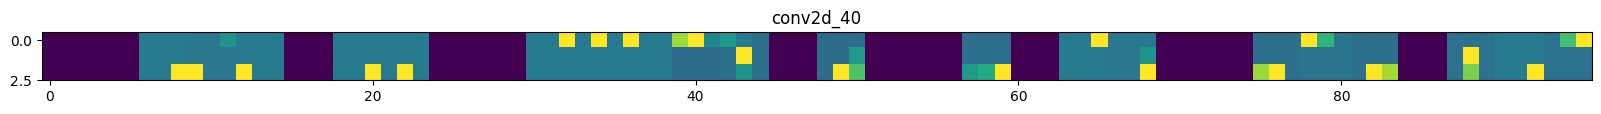

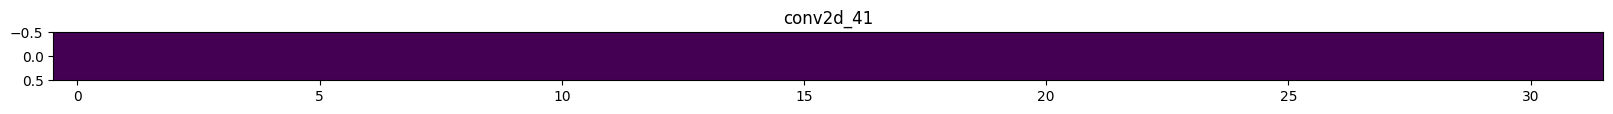

In [98]:
# Create a new model that outputs feature maps
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# Select an image from the test set
img_l1 = test_images[10]
img_l1 = img.reshape(1, 28, 28, 1)

# Get feature maps for the selected image
feature_maps = visualization_model.predict(img_l1)

# Plot the feature maps from the first convolutional block
layer_names = [layer.name for layer in model.layers]

# Only visualize the feature maps for the Conv2D layers
for layer_name, feature_map in zip(layer_names, feature_maps):
    if 'conv' not in layer_name:
        continue
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
        # Postprocess the feature to make it visually palatable
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')

        # Tile each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x

    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()


In [99]:
# summarize feature map size for each conv layer

# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_28 (None, 28, 28, 32)
1 conv2d_29 (None, 28, 28, 64)
2 conv2d_30 (None, 28, 28, 128)
4 conv2d_31 (None, 28, 28, 256)
8 conv2d_32 (None, 14, 14, 192)
9 conv2d_33 (None, 14, 14, 256)
11 conv2d_34 (None, 14, 14, 256)
15 conv2d_35 (None, 7, 7, 128)
16 conv2d_36 (None, 7, 7, 64)
19 conv2d_37 (None, 3, 3, 128)
20 conv2d_38 (None, 3, 3, 256)
22 conv2d_39 (None, 3, 3, 128)
24 conv2d_40 (None, 3, 3, 64)
25 conv2d_41 (None, 3, 3, 32)


In [100]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [21]:
# Train the model
MCNN_14=model.fit(X_train, Y_train, epochs=100,batch_size=64,validation_data=(X_test, Y_test))
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

Epoch 1/100
938/938 [==============================] - 72s 62ms/step - loss: 0.8818 - accuracy: 0.6610 - val_loss: 0.5270 - val_accuracy: 0.8028
Epoch 2/100
938/938 [==============================] - 55s 58ms/step - loss: 0.4919 - accuracy: 0.8275 - val_loss: 0.4013 - val_accuracy: 0.8530
Epoch 3/100
938/938 [==============================] - 54s 58ms/step - loss: 0.4289 - accuracy: 0.8517 - val_loss: 0.3633 - val_accuracy: 0.8698
Epoch 4/100
938/938 [==============================] - 54s 58ms/step - loss: 0.3841 - accuracy: 0.8653 - val_loss: 0.3386 - val_accuracy: 0.8750
Epoch 5/100
938/938 [==============================] - 55s 58ms/step - loss: 0.3613 - accuracy: 0.8743 - val_loss: 0.3328 - val_accuracy: 0.8849
Epoch 6/100
938/938 [==============================] - 54s 58ms/step - loss: 0.3416 - accuracy: 0.8810 - val_loss: 0.3364 - val_accuracy: 0.8840
Epoch 7/100
938/938 [==============================] - 54s 58ms/step - loss: 0.3289 - accuracy: 0.8878 - val_loss: 0.2917 - val_ac

In [23]:
probability_model2 = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [24]:
predictions2 = probability_model2.predict(test_images)

313/313 [==============================] - 2s 7ms/step


In [25]:
predictions2[3]

array([0.08533675, 0.23196931, 0.08533675, 0.08533675, 0.08533675,
       0.08533675, 0.08533675, 0.08533675, 0.08533675, 0.08533675],
      dtype=float32)

In [26]:
np.argmax(predictions2[0])

9

In [27]:
def plt_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plt_values_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [29]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [ ]:
i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt_image(i, predictions2[i], test_labels, test_images)
plt.subplot(1,2,2)
plt_values_array(i, predictions2[i],  test_labels)
plt.show()

In [ ]:
# plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plt_image(i, predictions2[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plt_values_array(i, predictions2[i], test_labels)
plt.tight_layout()
plt.show()

In [34]:
# Save the Model
model.save('MCNN_14_4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


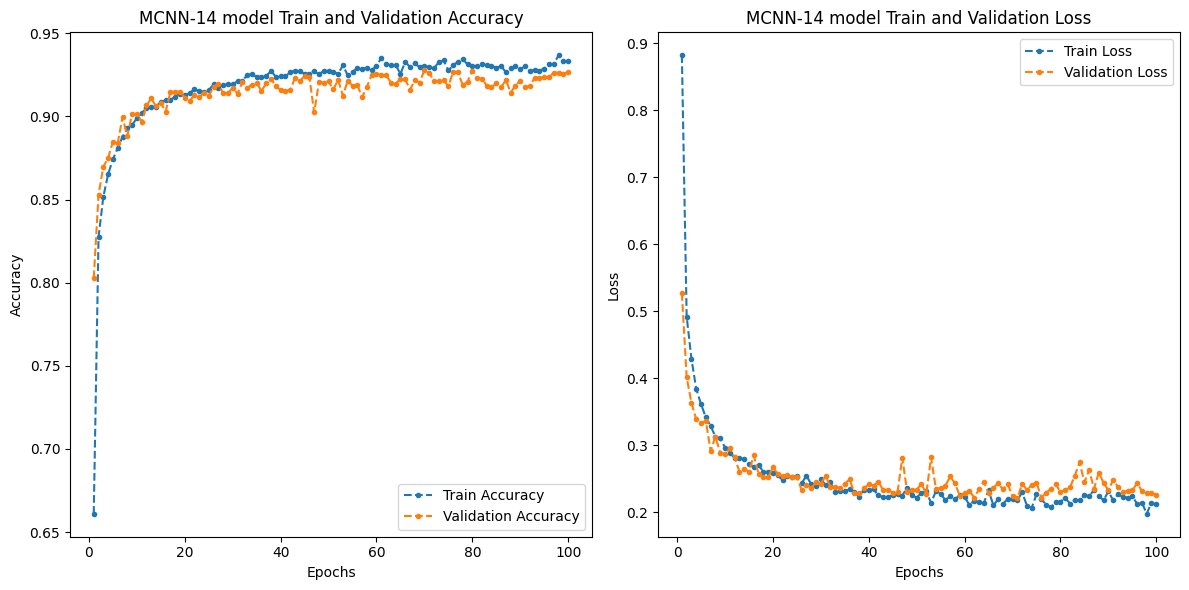

In [47]:
import matplotlib.pyplot as plt

# Displaying curves of loss and accuracy during training
acc = MCNN_14.history['accuracy']
val_acc = MCNN_14.history['val_accuracy']
loss = MCNN_14.history['loss']
val_loss = MCNN_14.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy on the left side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', marker='o', linestyle='dashed',markersize=3)
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='dashed',markersize=3)
plt.title('MCNN-14 model Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss on the right side
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='dashed',markersize=3)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='dashed',markersize=3)
plt.title('MCNN-14 model Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


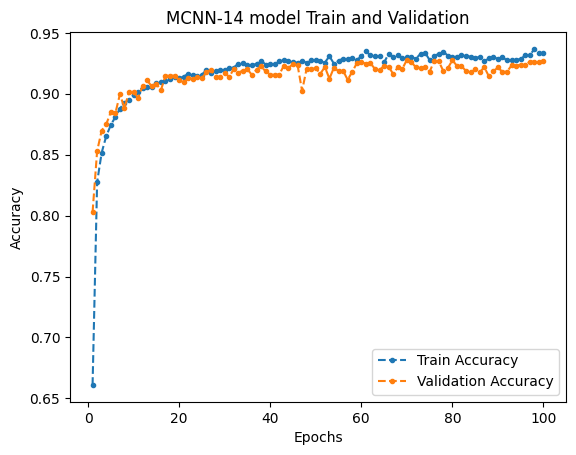

In [46]:
# plot accuracy
plt.plot(epochs, acc, label='Train Accuracy', marker='o', linestyle='dashed',markersize=3)
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='dashed',markersize=3)
plt.title('MCNN-14 model Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

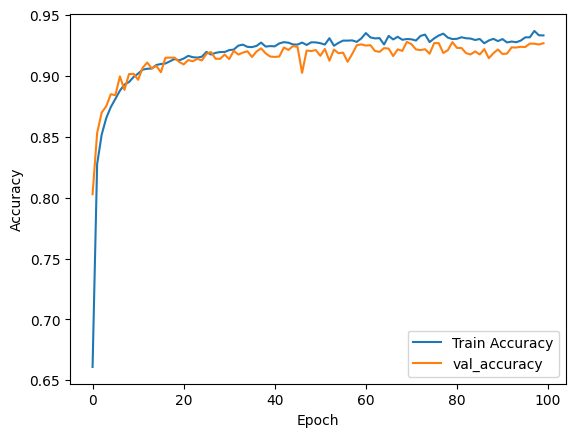

In [36]:
# plot accuracy
plt.plot(MCNN_14.history['accuracy'], label='Train Accuracy')
plt.plot(MCNN_14.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.6, 1])
plt.legend(loc='lower right')

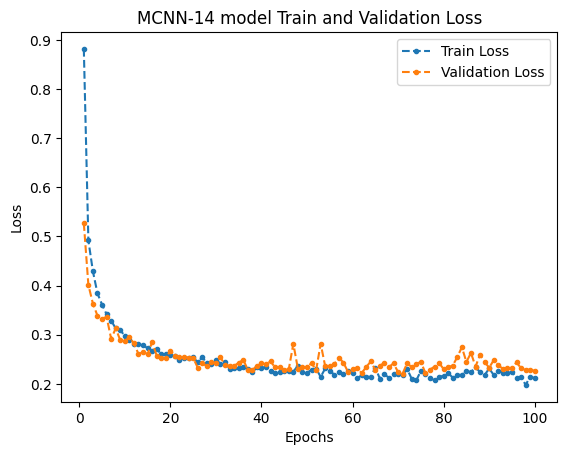

In [49]:
# Plot loss
plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='dashed',markersize=3)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='dashed',markersize=3)
plt.title('MCNN-14 model Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

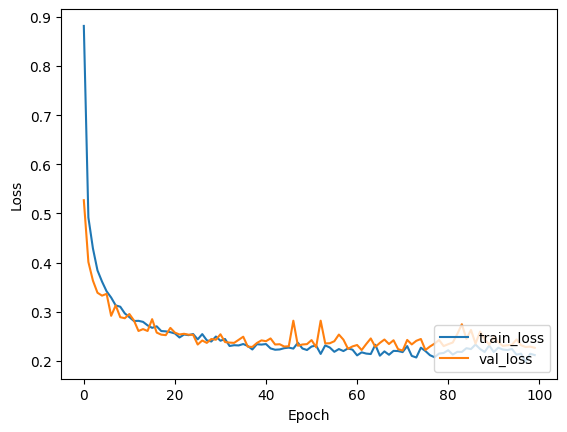

In [37]:
# plot accuracy
plt.plot(MCNN_14.history['loss'], label='train_loss')
plt.plot(MCNN_14.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.73, 1])
plt.legend(loc='lower right')

In [ ]:
# Evaluate the model  --> first method
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_real = np.argmax(Y_test, axis = 1)

# display result of evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
print(f"Test loss: {test_loss: 0.2f}")


In [ ]:
# Evaluate the model  --> first method
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_real = np.argmax(Y_test, axis = 1)

# display result of evaluate the model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
print(f"Test loss: {test_loss: 0.2f}")


313/313 [==============================] - 2s 5ms/step - loss: 0.2649 - accuracy: 0.9308
Test accuracy: 93.08%
Test loss:  0.26


In [39]:
print(classification_report(y_real, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.92      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.92      0.89      0.91      1000
       Dress       0.90      0.95      0.93      1000
        Coat       0.88      0.90      0.89      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.82      0.70      0.76      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



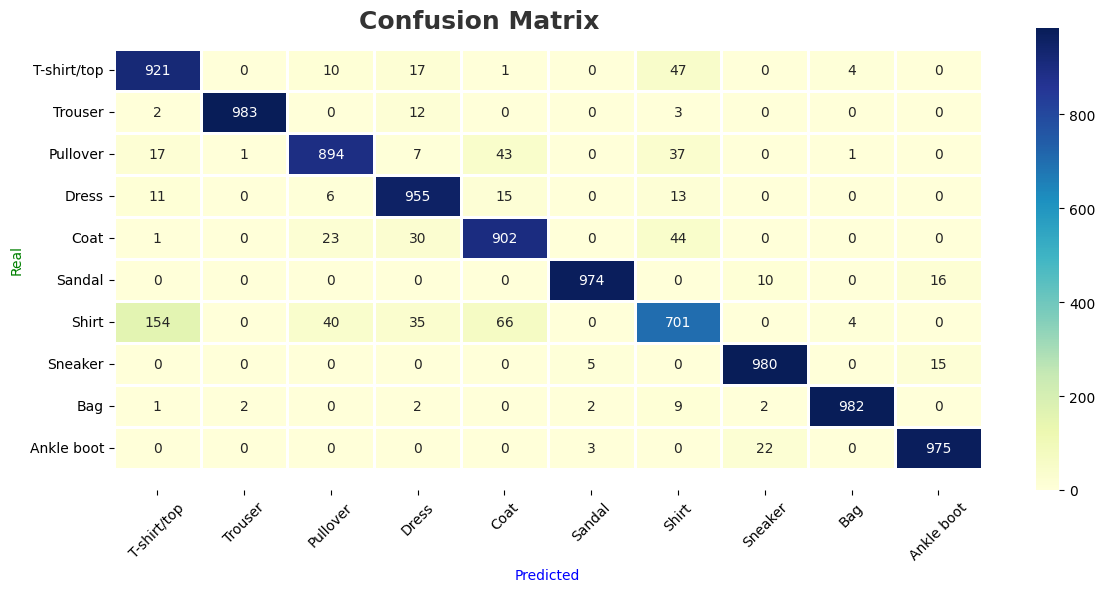

In [40]:
# display confusion matrix
fig, ax = plt.subplots(1,1,figsize=(14, 6))
sns.heatmap(confusion_matrix(y_real, y_pred), xticklabels=class_names, yticklabels=class_names,annot=True, linewidths=2,cmap="YlGnBu", linecolor='white', ax=ax,fmt='d')
fig.text(s="Confusion Matrix", size=18,fontweight='bold', fontname='DejaVu Sans', y=0.88,x=0.30,alpha=0.8)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted', color='blue')
plt.ylabel('Real', color='green')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
# plt.show()

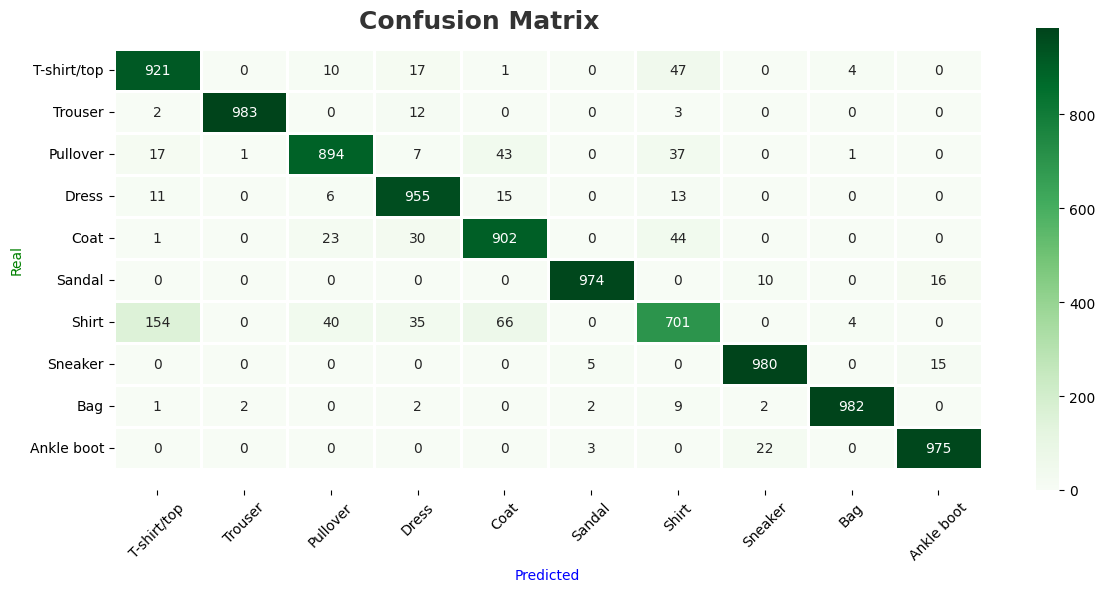

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_real and y_pred are defined, as well as class_names

# display confusion matrix
fig, ax = plt.subplots(1,1,figsize=(14, 6))
sns.heatmap(confusion_matrix(y_real, y_pred), xticklabels=class_names, yticklabels=class_names,
            annot=True, cmap="Greens", linewidths=2, linecolor='white', ax=ax,fmt='d')  # Added cmap="YlGnBu" for color

fig.text(s="Confusion Matrix", size=18, fontweight='bold', fontname='DejaVu Sans', y=0.88, x=0.30, alpha=0.8)

# Adjust the limit to fix the half-cut-off issue
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted', color='blue')
plt.ylabel('Real', color='green')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
